In [1]:
rejected_system_prompt = """
    You are an HR assistant helping to communicate candidate evaluation results. 
    Your task is to generate a short, professional, and polite rejection reason for an applicant, 
    based on the provided skills analysis comparing their CV with the job description.

    The skills analysis contains:
    - matched skills
    - missing skills
    - additional skills
    - a score (0-100)

    Instructions:
    - Clearly state that the applicant does not meet the requirements.
    - Highlight the key missing skills concisely.
    - Optionally mention strengths (matched skills) positively.
    - Keep the tone formal and polite.
    - Limit the response to 2–3 sentences.
    """

In [2]:
system_msg_node2 = """
You are a hiring assistant performing skill matching between a candidate's resume and a job description.

You will receive:
1. Extracted skills from the candidate's resume (array of strings)
2. Job description text

**Your tasks:**

1. **Semantic skill comparison**:  
   - Identify equivalent skills even if phrased differently.  
   - Treat variations, synonyms, abbreviations, and related phrasing as matches (e.g., "js" = "javascript", "machine learning" = "ML").  
   - Consider senior/higher-level certifications or qualifications as covering all lower levels. For example:
     - If the job requires an associate certification and the candidate has a professional certification in the same track, treat the associate requirement as fulfilled.
     - Do not list the lower-level skill in `missing` nor the higher-level one in `additional` in such cases.

2. **Contextual inference**:  
   - Infer skills the candidate likely has from context (e.g., someone with AWS Solutions Architect Professional is assumed to have AWS Solutions Architect Associate).
   - Do not penalize the candidate for minor naming differences or broader categories.

3. **Categorize skills into:**
   - `matched`: Skills explicitly or implicitly present in both resume and job description.
   - `missing`: Skills required in the job description that are *not* present or covered by an equivalent/higher-level skill in the resume.
   - `additional`: Skills in the resume that are relevant to the job but not listed as requirements.

4. **Calculate score**:  
   - `score` = (number of matched required skills ÷ total required skills) × 100.  
   - Round to the nearest whole number.

5. **Return ONLY valid JSON** following this structure exactly:

{
  "skills_analysis": {
    "matched": string[],
    "missing": string[],
    "additional": string[],
    "score": number
  }
}

**Rules:**
- Always output valid JSON — no explanations or text outside the JSON.
- Do not duplicate skills across categories.
- Normalize all skill names to lowercase.
"""

In [ ]:
job_description = """
About the job
Company Description

Aralects is developing a gamified, self-paced app focused on teaching Arabic dialects like Egyptian, Lebanese, and Emirati to enhance real-world conversational skills. Personalized learning pathways powered by AI aim to make language learning more engaging and accessible. The company is committed to creating a culturally immersive platform for mastering Arabic dialects, catering to a wide audience for professional growth or personal interest.

Role Description

We're looking for a passionate AI Engineer to join Aralects on a full-time basis (remote or hybrid). You'll be working alongside experts in AI, NLP, and language learning, helping to shape a next-generation platform for Arabic learners worldwide. This is a chance to make a real impact, contribute to a meaningful product, and be part of a collaborative, ambitious team.

We welcome candidates who are eager to grow their skills and contribute in areas like: AI agent development, deep learning, large language model (LLM) fine-tuning, Retrieval-Augmented Generation (RAG), speech processing, prompt engineering, and more.

Responsibilities

Design, build, and optimize AI-driven features for language learning, including conversational agents and recommendation systems
Develop tools for processing Arabic dialects (morphological analyzers, generators, speech-to-text, text-to-speech, alignment, automatic annotation, etc.)
Contribute to backend development, building scalable APIs and services to support AI features
Fine-tune LLMs and other AI models for educational and language learning applications
Stay up-to-date on the latest research and best practices in AI, deep learning, and NLP
Collaborate closely with the software team to integrate AI components into the Aralects platform
Document solutions and share insights with the team
(Bonus) Contribute to research initiatives or publishing


Qualifications

3+ years of experience (projects, industry, not academic) in Python programming
1+ years of hands-on experience with PyTorch (academic or industry projects)
1+ years of experience with Arabic NLP, language technology, or similar linguistic AI projects
Fluency in Arabic is required as the role involves developing and evaluating Arabic language learning materials and technologies.
Bachelor or Masters degree (completed or in progress) in Computer Science, AI, Computational Linguistics, Machine Learning, or a related field
Experience with Python backend development (e.g., FastAPI, Django, Node.js), including designing APIs and integrating AI models into production systems
Familiarity with frontend frameworks (e.g., React, Next.js, Vue) and integrating backend services with user interfaces
Good understanding of deploying, maintaining, and monitoring AI models in production environments
Proficiency in using Docker for containerization and deployment
Experience with cloud platforms (e.g., AWS, GCP, Azure) and CI/CD pipelines is a strong plus
Good command of software version control (e.g., Git) and collaborative development workflows
Bonus: Experience with data engineering, MLOps, or research publication"""

cv_txt = """Abdallah Hablus
abdallahhabluss@gmail.com | Linkedin | Github | +201065958796
EDUCATION
Tanta University	Sep. 2022 – Jul. 2027
Bachelor of Engineering in Artificial Intelligence GPA: 3.88 / 4.00
RELEVANT COURSEWORK

 
•	Computer Architecture
•	Data Structures and Algorithms
•	Object-Oriented Programming
 
•	Machine Learning
•	Neural Networks
•	Web Development
 
TECHNICAL SKILLS
Languages: Python, C++, JavaScript
Libraries and Tools: Git, Matplotlib, Tensorflow, Pandas, Pytorch
PROJECTS
Cognitive Performance Prediction | Python, TensorFlow, Pandas
Developed a machine learning model to predict human cognitive performance using a custom-built Feedforward Neural
Network (FNN), TensorFlow FNN, and Linear Regression. Implemented data preprocessing, feature scaling, and outlier removal techniques. Evaluated model performance using MAE, RMSE, and R2.
GitHub
Lung Pneumonia Detection | MLP, CNN, KAN
Implemented the KAN (Kolmogorov-Arnold Network) architecture for lung pneumonia detection and explored its potential.
Compared its performance with traditional MLP and CNN models, investigating how KAN could provide a novel approach in medical image classification.
COURSES AND CERTIFICATES
•	Supervised Machine Learning (Coursera | Stanford | DeepLearning.AI)
•	Neural Networks and Deep Learning (Coursera | DeepLearning.AI)
•	Improving Deep Neural Networks (Coursera | DeepLearning.AI)
•	Structuring Machine Learning Projects (Coursera | DeepLearning.AI)
•	IELTS Certificate | Overall Band Score: 7.5
EXTRACURRICULAR ACTIVITIES
Sales Team Member	Dec. 2023 – Jun. 2024
AIESEC in Egypt
•	Assisted in applying sales strategies, followed up on leads, and updated tracking tools (Podio, Slack, spreadsheets)
•	Participated in team meetings, events, and ensured proper information management
•	Supported the application process for outgoing volunteers and maintained communication with leads
Usher	Apr. 2024
Breadfast Launch Activation	Gizeret El Ward Club, Mansoura
•	Assisted in helping attendees get to know the Breadfast brand during a 3-day activation event
•	Helped with on-site sign-ups for new customers
•	Gathered and organized data for event follow-up and marketing analysis
•	Provided general assistance to ensure the smooth operation of the event
"""

prevsystem_msg_node1 = """
You are a resume pre-screening assistant. 
You will receive two inputs: (1) Resume text, (2) Job description.

Your tasks:
1. **Extract the following entities** from the resume:  
   - name (string)
   - email (string)
   - phone (string)
   - years_of_experience (number, based on total relevant experience in years)
   - skills (array of strings, extracted from the resume and relevant to the job)

2. **Implement Knockout Question checks** against the job’s non-negotiable requirements:  
   - extract job requirements from the job description, and rank them by importance.
   - If any mandatory skill or requirement listed in the job description is missing, or if years of experience is below the required minimum, set `pre_screening_status` to `"Fail"`.
   - Otherwise, set `pre_screening_status` to `"Pass"`.

3. **Do not perform technical skill analysis here** — leave the `skill_analysis` object with empty arrays and a score of 0 for now.
4. **Do not assign a final_disposition** — leave it empty or null.

5. **Return ONLY a JSON object** that strictly follows this schema:

{
  "name": string,
  "email": string,
  "phone": string,
  "years_of_experience": number,
  "skills": string[],
  "pre_screening_status": "Pass" | "Fail",
  "job_requirements": string[],
  "skills_analysis": {
    "matched": string[],
    "missing": string[],
    "additional": string[],
    "score": number
  },
  "final_decision": "Interview" | "Phone Screen" | "Rejected"
}

Rules:
- Always return valid JSON.
- Do not include any extra text outside of the JSON.
- Ensure extracted fields are as accurate as possible based on the resume.
- If information is missing, leave the value as an empty string, empty array, or 0, but keep the JSON keys present.
- Skills should be deduplicated and in lowercase.

Example output:
{
  "name": "Jane Doe",
  "email": "jane.doe@email.com",
  "phone": "+1 555-123-4567",
  "years_experience": 6,
  "skills": ["python", "sql", "aws"],
  "pre_screening_status": "Pass",
  "job_requirements": ["python", "data analysis", "aws"],
  "skill_analysis": {
    "matched": [],
    "missing": [],
    "additional": [],
    "score": 0
  },
  "final_decision": ""
}
"""

system_msg_node1 = """You are a resume pre-screening assistant.

You will receive:
1. Resume text
2. Job description text

Your tasks:

1. **Entity extraction from the resume**: Extract the following:
   - `name`: Full name (string)
   - `email`: Email address (string)
   - `phone`: Phone number (string)
   - `years_of_experience`: Total relevant experience in years (number)
   - `skills`: Array of strings representing relevant skills, certifications, and tools from the resume. Normalize to lowercase, deduplicate, and return only those relevant to the job description.

2. **Knockout Question checks**:  
   - If *any* mandatory requirement from the job description is not met, OR `years_of_experience` is below the stated minimum, set `"pre_screening_status"` to `"Fail"`.  
   - Otherwise, set `"pre_screening_status"` to `"Pass"`.

3. **Leave skills_analysis empty**:  
   - Set `skills_analysis` fields to empty arrays and `score` to 0 for now.

4. **Leave final_decision blank**:  
   - Set `final_decision` to an empty string.

5. **Return ONLY valid JSON** following this schema exactly:

{
  "name": string,
  "email": string,
  "phone": string,
  "years_of_experience": number,
  "skills": string[],
  "pre_screening_status": "Pass" | "Fail",
  "skills_analysis": {
    "matched": string[],
    "missing": string[],
    "additional": string[],
    "score": number
  },
  "final_decision": "Interview" | "Phone Screen" | "Rejected" | ""
}

**Rules:**
- Always output valid JSON — no extra commentary or text.
- If any value is missing, leave it as an empty string, empty array, or 0.
- Skills should be in lowercase and deduplicated.
"""

In [4]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader("cv.pdf")
pages = loader.load()
cv_text = "\n\n".join([p.page_content for p in pages])


In [5]:
from typing import List, Literal, TypedDict

class SkillAnalysis(TypedDict):
    """
    Analysis of the skills required for the job.
    """
    matched: list[str]
    missing: list[str]
    additional: list[str]
    score: float
    

class SharedState(TypedDict):
    """
    Shared state for the agent.
    """
    name: str
    email: str
    phone: str
    years_of_experience: int
    skills: List[str]
    pre_screening_status: Literal['Pass', 'Fail']
    skills_analysis: SkillAnalysis
    final_decision: Literal['Interview', 'Phone Screen', 'Rejected']
    rejection_reason: str | None  # Added for rejection reason
    

In [6]:
from pydantic import SecretStr
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
load_dotenv()


OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

LLM = ChatGroq(model="openai/gpt-oss-120b", temperature=0, api_key=SecretStr(OPENAI_API_KEY) if OPENAI_API_KEY else None)

In [7]:
from langchain_core.messages import SystemMessage, HumanMessage
import json





def input_and_prescreening(state: SharedState) -> SharedState:
    print("Running input_and_prescreening")
    cv_message = HumanMessage(content=cv_txt)
    jd_message = HumanMessage(content=job_description)
    sys_message = SystemMessage(content=system_msg_node1)
    
    messages = [sys_message, cv_message, jd_message]
    
    response = LLM.invoke(messages)
    
    data = json.loads(str(response.content))
    
    # Update the shared state
    state["name"] = data["name"]
    state["email"] = data["email"]
    state["phone"] = data["phone"]
    state["years_of_experience"] = data["years_of_experience"]
    state["skills"] = data["skills"]
    state["pre_screening_status"] = data["pre_screening_status"]
    state["skills_analysis"] = data["skills_analysis"]
    state["final_decision"] = data["final_decision"]
    state["rejection_reason"] = None  # Initialize rejection reason as None
    return state

In [8]:
def skills_analysis(state: SharedState) -> SharedState:
    print("Running skills_analysis")
    sys_message = SystemMessage(content=system_msg_node2)
    cv_skills = state["skills"]
    cv_message = HumanMessage(content=", ".join(cv_skills) if isinstance(cv_skills, list) else str(cv_skills))
    jd_message = HumanMessage(content=job_description)
    
    messages = [sys_message, cv_message, jd_message]
    
    response = LLM.invoke(messages)
    data = json.loads(str(response.content))
    state["skills_analysis"] = data["skills_analysis"]
    print(state["skills_analysis"])
    return state

In [9]:
def router1(state: SharedState) -> str:
    print("Running router1")
    """
    Route the state to the appropriate function based on the final decision.
    """ 
    pre_screening_status = state["pre_screening_status"]

    if pre_screening_status == "Pass":
        return "skills_analysis"
    elif pre_screening_status == "Fail":
        return "reject"
    else:
        raise ValueError(f"Invalid pre-screening status: {pre_screening_status}")

def router2(state: SharedState) -> str:
    print("Running router2")
    """
    Route the state to the appropriate function based on the final decision.
    """ 
    score = state["skills_analysis"]["score"]

    if score > 80:
        return "Interview"
    elif 50 <= score <= 80:
        return "Phone Screen"
    elif score < 50:
        return "Rejected"
    else:
        raise ValueError(f"Invalid score: {score}")

def interview(state: SharedState) -> SharedState:
    print("Running interview")
    state["final_decision"] = "Interview"
    return state
    

def phone_screen(state: SharedState) -> SharedState:
    print("Running phone_screen")
    state["final_decision"] = "Phone Screen"
    return state
    

def reject(state: SharedState) -> SharedState:
    print("Running reject")
    state["final_decision"] = "Rejected"
    sys_message = SystemMessage(content=rejected_system_prompt)
    messages = [sys_message, HumanMessage(content=json.dumps(state["skills_analysis"], indent=2))]
    response = LLM.invoke(messages)
    state["rejection_reason"] = str(response.content)
    
    return state

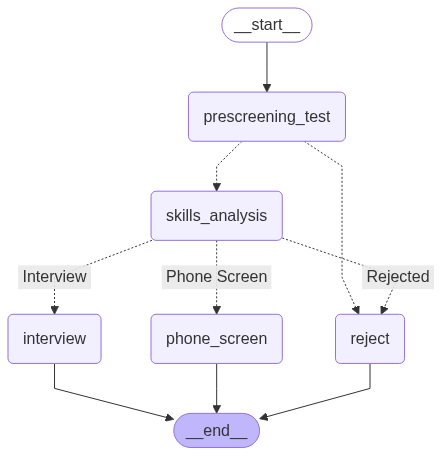

In [10]:
from langgraph.graph import START, StateGraph, END
from IPython.display import Image, display


builder = StateGraph(SharedState)


builder.add_node("prescreening_test", input_and_prescreening)
builder.add_node("skills_analysis", skills_analysis)
builder.add_node("interview", interview)
builder.add_node("phone_screen", phone_screen)
builder.add_node("reject", reject)  

builder.add_edge(START, "prescreening_test")
builder.add_conditional_edges("prescreening_test", router1, {
    "skills_analysis": "skills_analysis",
    "reject": "reject"
})
builder.add_conditional_edges("skills_analysis", router2, {
    "Interview": "interview",
    "Phone Screen": "phone_screen",
    "Rejected": "reject"
})
# Add this line to your graph builder
builder.add_edge("reject", END)
builder.add_edge("interview", END)
builder.add_edge("phone_screen", END)
graph = builder.compile()


display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
# Create an initial empty state
initial_state = SharedState(
    name="",
    email="",
    phone="",
    years_of_experience=0,
    skills=[],
    pre_screening_status="Fail",
    skills_analysis={"matched": [], "missing": [], "additional": [], "score": 0},
    final_decision="Rejected",
    rejection_reason=""
)


# Run the compiled graph
final_state = graph.invoke(initial_state)

# See what changed
print(json.dumps(final_state, indent=2))

Running input_and_prescreening
Running router1
Running reject
{
  "name": "Abdallah Hablus",
  "email": "abdallahhabluss@gmail.com",
  "phone": "+201065958796",
  "years_of_experience": 0,
  "skills": [
    "python",
    "pytorch",
    "tensorflow",
    "machine learning",
    "deep learning",
    "neural networks",
    "git",
    "javascript"
  ],
  "pre_screening_status": "Fail",
  "skills_analysis": {
    "matched": [],
    "missing": [],
    "additional": [],
    "score": 0
  },
  "final_decision": "Rejected",
  "rejection_reason": "We appreciate your interest in the position; however, after reviewing your application, we have determined that your profile does not meet the required qualifications for this role. The essential skills and experience outlined in the job description were not demonstrated in your submission. We wish you success in your future endeavors."
}
